In [1]:
# import particles 
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# def next_angle(q, u):
#     # q_init: array (2,) containing the inital angles
#     # u:      array (2,) containing the change rate
#     return q + u

# def current_position(q, l):
#     # q: array (2,) containing the two angles
#     # l: array (2,) containing the limb lengths 
#     x = l * np.cos(q[0]) + l * np.cos(q[0] + q[1])
#     y = l * np.sin(q[0]) + l * np.sin(q[0] + q[1])
#     return np.array([x, y])

def current_position(q, l):
    # q: array (2,) containing the two angles
    # l: array (2,) containing the limb lengths 
    x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
    y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
    return np.array([x, y])

# Data Simulation

In [11]:
# def generate_one_task(limb_length, n_episode=150, n_timesteps=10):
#     dof = 2
#     angles = list()
#     positions = list()
#     for _ in range(n_episode):
#         q = np.random.uniform(low= -np.pi, high= np.pi, size=dof) # observation, the angle, uniform [-pi, pi]
#         angles.append(q)
#         u = np.random.randn(dof, n_timesteps) # action, the change rate of angles
#         q += u.sum(axis=1)
#         position = current_position(q, limb_length)
#         positions.append(position)
    
#     return positions, angles

In [3]:
n_tasks=1000 
n_episode=150
n_timesteps=10

def simulate_data(n_tasks=1000, n_episode=150, n_timesteps=10):
    dof = 2
    angles = list()
    positions = list()
    # generate limb length for each task
    lens = np.random.normal(loc=1, scale=np.sqrt(0.3), size=(n_tasks, 2))
    for i in range(n_tasks):
        # position, angle = generate_one_task(lens[i], n_episode=150, n_timesteps=10)
        limb_length = lens[i]
        for _ in range(n_episode):
            q = np.random.uniform(low= -np.pi, high= np.pi, size=dof) # observation, the angle, uniform [-pi, pi]
            angles.append(q)
            u = np.random.randn(dof, n_timesteps) # action, the change rate of angles
            q += u.sum(axis=1)
            position = current_position(q, limb_length)
            positions.append(position)
        # angles.extend(angle)
        # positions.extend(position)

    angles = np.stack(angles, axis=0)
    positions = np.stack(positions, axis=0)

    assert angles.shape == positions.shape # their shape should be both (n_tasks*n_episode*n_timesteps, 2)
    return positions, angles

In [4]:
positions, angles = simulate_data()

In [5]:
positions.shape, angles.shape

((150000, 2), (150000, 2))

In [13]:
np.savez_compressed('./two_link_arm_pretraining_data.npz',x=angles,y=positions)

# Build model

In [4]:
input_length = 2
latent_dim = 512
output_length = 2

model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(input_length,)),
    Dropout(rate=0.5),
    Dense(units=latent_dim, activation='tanh'),
    Dense(units=output_length),
  ])

2022-12-21 13:54:22.061853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 512)               1536      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 265,218
Trainable params: 265,218
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

# pretraining multi-task

In [63]:
loaded = np.load('./two_link_arm_pretraining_data.npz')
# print(np.array_equal(angles , loaded['x']))
# print(np.array_equal(positions , loaded['y']))
angles = loaded['x']
positions = loaded['y']

In [64]:
test_ratio = 0.1

In [71]:
x_train, x_test, y_train, y_test = train_test_split(angles, positions, test_size=test_ratio, random_state=666)
model.fit(x_train, y_train, epochs=5, batch_size=128)

Epoch 1/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.9519 - mean_absolute_error: 0.7618 - val_loss: 0.5816 - val_mean_absolute_error: 0.5850
Epoch 2/5
1055/1055 [==============================] - 5s 4ms/step - loss: 0.5368 - mean_absolute_error: 0.5597 - val_loss: 0.4297 - val_mean_absolute_error: 0.4977
Epoch 3/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.4500 - mean_absolute_error: 0.5138 - val_loss: 0.3852 - val_mean_absolute_error: 0.4733
Epoch 4/5
1055/1055 [==============================] - 6s 5ms/step - loss: 0.4162 - mean_absolute_error: 0.4962 - val_loss: 0.3576 - val_mean_absolute_error: 0.4568
Epoch 5/5
1055/1055 [==============================] - 5s 5ms/step - loss: 0.3961 - mean_absolute_error: 0.4852 - val_loss: 0.3504 - val_mean_absolute_error: 0.4554


In [73]:
pretrained = tf.keras.models.load_model('saved_model/my_model')

In [38]:
loss = history.history['loss']

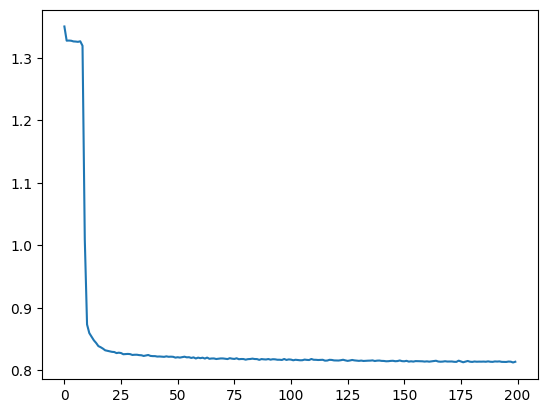

In [39]:
plt.plot(loss)

In [17]:
def plot_model(model):
    loss = model.history.history['loss']
    plt.plot(loss)

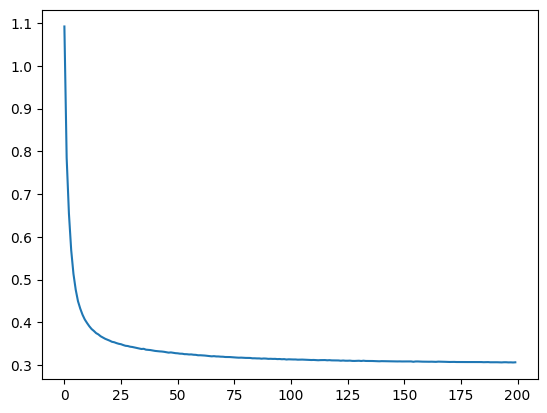

In [18]:
plot_model(model)

# pretraining reptile

In [29]:
input_length = 2
latent_dim = 512
output_length = 2

model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(input_length,)),
    Dropout(rate=0.5),
    Dense(units=latent_dim, activation='tanh'),
    Dense(units=output_length),
  ])

In [30]:
n_tasks = 1000
n_episode = 150 
meta_step_size = 0.25
eval_interval = 1
epochs = 200

model.compile()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_mse = tf.keras.losses.MeanSquaredError()

Code Adapted from [Few-Shot learning with Reptile](https://keras.io/examples/vision/reptile/)

In [31]:
training_loss = []
loaded = np.load('./two_link_arm_pretraining_data.npz')
angles = loaded['x']
positions = loaded['y']

for epoch in range(epochs):
    losses = []
    for meta_iter in range(n_tasks):
        frac_done = meta_iter / n_tasks
        cur_meta_step_size = (1 - frac_done) * meta_step_size
        # Temporarily save the weights from the model.
        old_vars = model.get_weights()
        # Get a sample from the full dataset.
        limb_length = np.random.normal(loc=1, scale=np.sqrt(0.3), size=(2,))
        x_train = angles[meta_iter*n_episode:(meta_iter+1)*n_episode]
        y_train = positions[meta_iter*n_episode:(meta_iter+1)*n_episode]

        # for i in range(0, positions.shape[0], batch_size):
        #     with tf.GradientTape() as tape:
        #         preds = model(x_train[i:i+batch_size])
        #         truth = y_train[i:i+batch_size]
        #         loss = loss_mse(truth, preds)
        #     grads = tape.gradient(loss, model.trainable_weights)
        #     optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        with tf.GradientTape() as tape:
            preds = model(x_train)
            loss = loss_mse(y_train, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        new_vars = model.get_weights()
        for var in range(len(new_vars)):
            new_vars[var] = old_vars[var] + ((new_vars[var] - old_vars[var]) * cur_meta_step_size)
        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_vars)
        losses.append(loss_mse(y_train, model(x_train)))
    training_loss.append(np.mean(losses))
    
    if (epoch+1) % eval_interval == 0:
        print(f"Epoch: {epoch+1}: training MSE = {np.mean(losses)}")

Epoch: 1: training MSE = 1.0808132886886597
Epoch: 2: training MSE = 0.7943138480186462
Epoch: 3: training MSE = 0.6687605977058411
Epoch: 4: training MSE = 0.6011272072792053
Epoch: 5: training MSE = 0.5563327670097351
Epoch: 6: training MSE = 0.5227055549621582
Epoch: 7: training MSE = 0.49640318751335144
Epoch: 8: training MSE = 0.4751602113246918
Epoch: 9: training MSE = 0.45748549699783325
Epoch: 10: training MSE = 0.4424794316291809
Epoch: 11: training MSE = 0.4296622574329376
Epoch: 12: training MSE = 0.41859424114227295
Epoch: 13: training MSE = 0.40897098183631897
Epoch: 14: training MSE = 0.4005781412124634
Epoch: 15: training MSE = 0.3932211697101593
Epoch: 16: training MSE = 0.3867909610271454
Epoch: 17: training MSE = 0.3810650408267975
Epoch: 18: training MSE = 0.37593504786491394
Epoch: 19: training MSE = 0.3713417947292328
Epoch: 20: training MSE = 0.36721208691596985
Epoch: 21: training MSE = 0.36345189809799194
Epoch: 22: training MSE = 0.35996922850608826
Epoch: 23: 

KeyboardInterrupt: 

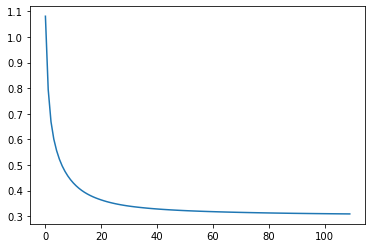

In [32]:
plt.plot(training_loss)

In [33]:
model.save('./two_link_arm_pretrained_R.model')

INFO:tensorflow:Assets written to: ./two_link_arm_pretrained_R.model\assets
